In [115]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from scipy import stats
import json
import os
import warnings

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Constants - matched with hyperparameter tuning
RANDOM_STATE = 42
CV_SPLITS = 10  # Consistent with hyperparameter tuning

# Create results directory
RESULTS_DIR = 'results/LDA_Storage_Condition_Classification'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Filter warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="Stochastic Optimizer")

In [116]:
# Data Preparation and Model Loading Functions
def prepare_data():
    """Load and prepare data consistently"""
    print("Loading data and preparing features...")
    # Use augmented_bakery_data.csv for consistency with other notebooks
    data = pd.read_csv('augmented_bakery_data.csv')
    
    # Encode labels
    le_product = LabelEncoder()
    le_storage = LabelEncoder()
    data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
    data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])
    
    # Prepare features
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X_base = data[feature_cols]
    
    # Scale features on entire dataset
    scaler = StandardScaler()
    X_base_scaled = scaler.fit_transform(X_base)
    
    # Prepare datasets
    X_without_product = X_base_scaled
    X_with_product = np.column_stack([X_base_scaled, data['Product_Type_encoded'].values.reshape(-1, 1)])
    y_storage = data['Storage_Condition_encoded'].values
    
    print(f"\nDataset shapes:")
    print(f"X without product type: {X_without_product.shape}")
    print(f"X with product type: {X_with_product.shape}")
    print(f"Storage conditions: {dict(zip(le_storage.classes_, range(len(le_storage.classes_))))}")
    
    return X_with_product, X_without_product, y_storage, le_storage.classes_, feature_cols

def load_best_parameters():
    """Load best parameters from JSON file"""
    try:
        #with open('hyperparameter_tuning/LDA_storage_condition_results.json', 'r') as f:
        with open('hyperparameter_tuning/grid_search_lda_storage_condition_results.json', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print("Error: Could not find hyperparameter tuning results file.")
        print("Please run hyperparameter tuning first.")
        return None

def create_models(best_params, scenario='with_product_type'):
    """Create models with best parameters"""
    models = {}
    params = best_params[scenario]
    
    for model_name, model_params in params.items():
        if model_name == 'SVM':
            models[model_name] = SVC(**model_params, random_state=RANDOM_STATE, probability=True)
        elif model_name == 'Random Forest':
            models[model_name] = RandomForestClassifier(**model_params, random_state=RANDOM_STATE)
        elif model_name == 'KNN':
            models[model_name] = KNeighborsClassifier(**model_params)
        elif model_name == 'Neural Network':
            models[model_name] = MLPClassifier(**model_params, random_state=RANDOM_STATE)
        elif model_name == 'Logistic Regression':
            models[model_name] = LogisticRegression(**model_params, random_state=RANDOM_STATE)
    
    return models

In [117]:
# LDA Analysis Functions
def visualize_lda_projections(X, y, class_labels, title_suffix=""):
    """Visualize LDA projections of the data"""
    # Fit LDA on the full dataset
    lda = LDA(n_components=min(2, len(np.unique(y))-1))  # Use 2 components for visualization (or fewer if needed)
    X_lda = lda.fit_transform(X, y)
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'LDA1': X_lda[:, 0],
        'class': [class_labels[i] for i in y]
    })
    
    # Add LDA2 if available (only if we have more than 2 classes)
    if X_lda.shape[1] > 1:
        df['LDA2'] = X_lda[:, 1]
    else:
        # If only one LDA component, add a zero column for plotting
        df['LDA2'] = np.zeros(X_lda.shape[0])
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='LDA1', y='LDA2', hue='class', data=df, palette='viridis', s=100, alpha=0.7)
    plt.title(f'LDA Projection of Storage Conditions {title_suffix}')
    plt.xlabel('First Discriminant')
    plt.ylabel('Second Discriminant' if X_lda.shape[1] > 1 else 'No Second Discriminant')
    plt.grid(alpha=0.3)
    plt.legend(title='Storage Condition')
    
    plt.tight_layout()
    filename = f'lda_projection{"_" + title_suffix.lower().replace(" ", "_") if title_suffix else ""}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()
    
    # Return the LDA model and transformed data
    return lda, X_lda

def analyze_lda_coefficients(lda, feature_names, title_suffix=""):
    """Analyze and visualize the discriminant coefficients from LDA"""
    # Get the coefficients (scalings) of the linear discriminants
    if hasattr(lda, 'scalings_'):
        coefficients = lda.scalings_
    elif hasattr(lda, 'coef_'):
        coefficients = lda.coef_
    else:
        print("LDA model doesn't expose coefficient attributes")
        return None
    
    # Create a DataFrame for the coefficients
    coef_df = pd.DataFrame(
        coefficients, 
        index=feature_names,
        columns=[f'LD{i+1}' for i in range(coefficients.shape[1])]
    )
    
    # If too many features, just show top 15 by absolute value for the first discriminant
    if len(feature_names) > 15:
        top_features_idx = np.argsort(np.abs(coefficients[:, 0]))[-15:]
        top_features = [feature_names[i] for i in top_features_idx]
    else:
        top_features = feature_names
    
    # Plot top features for the first discriminant
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), [abs(coefficients[feature_names.index(f), 0]) for f in top_features])
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Absolute Coefficient Value')
    plt.title(f'Top Features for First Discriminant {title_suffix}')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    filename = f'lda_coefficients{"_" + title_suffix.lower().replace(" ", "_") if title_suffix else ""}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()
    
    return coef_df

def evaluate_models_with_lda(X, y, models, cv=CV_SPLITS):
    """Evaluate models using cross-validation with LDA"""
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    num_classes = len(np.unique(y))  # Number of unique classes in the target variable
    
    # First evaluate LDA as a standalone classifier
    print("\nEvaluating LDA as a standalone classifier...")
    lda_classifier = LDA(n_components=num_classes-1)
    lda_cv_scores = cross_val_score(lda_classifier, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    lda_y_pred = cross_val_predict(lda_classifier, X, y, cv=skf, n_jobs=-1)
    
    # Store LDA results
    results['LDA'] = {
        'fold_accuracies': lda_cv_scores,
        'mean_accuracy': lda_cv_scores.mean(),
        'std_accuracy': lda_cv_scores.std(),
        'confusion_matrix': confusion_matrix(y, lda_y_pred),
        'classification_report': classification_report(y, lda_y_pred)
    }
    
    print(f"LDA Classifier Final Results:")
    print(f"Mean accuracy: {results['LDA']['mean_accuracy']:.4f} ± {results['LDA']['std_accuracy']:.4f}")
    print("\nClassification Report:")
    print(results['LDA']['classification_report'])
    
    # Then evaluate other models with LDA preprocessing
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with LDA preprocessing...")
        
        pipeline = Pipeline([
            ('lda', LDA(n_components=num_classes - 1)),
            (model_name, model)
        ])
        
        cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
        y_pred = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)
        
        results[f"{model_name}+LDA"] = {
            'fold_accuracies': cv_scores,
            'mean_accuracy': cv_scores.mean(),
            'std_accuracy': cv_scores.std(),
            'confusion_matrix': confusion_matrix(y, y_pred),
            'classification_report': classification_report(y, y_pred),
            'model': model,  # Store the model for learning curves
            'pipeline': pipeline  # Store the pipeline for learning curves
        }
        
        print(f"{model_name}+LDA Final Results:")
        print(f"Mean accuracy: {results[f'{model_name}+LDA']['mean_accuracy']:.4f} ± {results[f'{model_name}+LDA']['std_accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[f"{model_name}+LDA"]['classification_report'])
    
    return results

In [118]:
# Visualization Functions
def plot_model_comparison(results_without, results_with):
    """Plot model comparison bar chart"""
    # Get models that are in both results
    models = sorted(set(results_without.keys()) & set(results_with.keys()))
    
    means_without = [results_without[model]['mean_accuracy'] for model in models]
    stds_without = [results_without[model]['std_accuracy'] for model in models]
    
    means_with = [results_with[model]['mean_accuracy'] for model in models]
    stds_with = [results_with[model]['std_accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, means_without, width, yerr=stds_without,
                    label='Without Product Type', capsize=5)
    rects2 = ax.bar(x + width/2, means_with, width, yerr=stds_with,
                    label='With Product Type', capsize=5)
    
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Model Comparison for Storage Condition Classification with LDA')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'lda_storage_condition_comparison.png'))
    plt.show()

def plot_confusion_matrices(results_without, results_with, class_labels):
    """Plot confusion matrices side by side for with/without product type"""
    # Get models that are in both results
    models = sorted(set(results_without.keys()) & set(results_with.keys()))
    
    for model_name in models:
        # Create two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        
        # Plot first confusion matrix (Without Product Type)
        sns.heatmap(results_without[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels, ax=ax1)
        ax1.set_title(f'{model_name} - Without Product Type')
        ax1.set_ylabel('Actual')
        ax1.set_xlabel('Predicted')
        
        # Plot second confusion matrix (With Product Type)
        sns.heatmap(results_with[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels, ax=ax2)
        ax2.set_title(f'{model_name} - With Product Type')
        ax2.set_ylabel('Actual')
        ax2.set_xlabel('Predicted')
        
        plt.tight_layout()
        filename = f'confusion_matrix_{model_name.lower().replace(" ", "_").replace("+", "_with_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.close()

def plot_learning_curves_pipeline(X, y, result_item, model_name, cv=CV_SPLITS):
    """Plot learning curves with confidence intervals for a pipeline"""
    # Use the pipeline stored in the results
    pipeline = result_item.get('pipeline')
    if pipeline is None:
        print(f"No pipeline found for {model_name}")
        return None
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y,
        train_sizes=train_sizes,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation Score', color='red', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='red')
    
    plt.title(f'Learning Curves - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    final_train = f"Final training score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}"
    final_val = f"Final validation score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}"
    plt.annotate(final_train, xy=(0.6, 0.2), xycoords='axes fraction')
    plt.annotate(final_val, xy=(0.6, 0.15), xycoords='axes fraction')
    
    plt.tight_layout()
    filename = f'learning_curve_{model_name.lower().replace(" ", "_").replace("+", "_with_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.close()
    
    return {
        'train_sizes': train_sizes,
        'train_scores': {'mean': train_mean, 'std': train_std},
        'val_scores': {'mean': val_mean, 'std': val_std}
    }

def perform_statistical_analysis(results_without, results_with):
    """Perform statistical analysis"""
    analysis_results = []
    
    print("\nStatistical Analysis Results:")
    print("=" * 50)
    
    # Get models that are in both results
    models = sorted(set(results_without.keys()) & set(results_with.keys()))
    
    for model in models:
        acc_without = results_without[model]['fold_accuracies']
        acc_with = results_with[model]['fold_accuracies']
        
        t_stat, p_value = stats.ttest_rel(acc_with, acc_without)
        improvement = (np.mean(acc_with) - np.mean(acc_without)) * 100
        
        result = {
            'Model': model,
            'Accuracy without Product': f"{np.mean(acc_without):.4f} ± {np.std(acc_without):.4f}",
            'Accuracy with Product': f"{np.mean(acc_with):.4f} ± {np.std(acc_with):.4f}",
            'Improvement (%)': f"{improvement:.2f}%",
            'p-value': f"{p_value:.4f}",
            'Significant': "Yes" if p_value < 0.05 else "No"
        }
        analysis_results.append(result)
        
        print(f"\n{model}:")
        print(f"- Without Product Type: {result['Accuracy without Product']}")
        print(f"- With Product Type: {result['Accuracy with Product']}")
        print(f"- Improvement: {improvement:.2f}%")
        print(f"- Statistical Significance (p < 0.05): {result['Significant']} (p = {p_value:.4f})")

    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv(os.path.join(RESULTS_DIR, 'lda_storage_condition_statistical_analysis.csv'), index=False)
    return results_df

In [119]:
# Summary Analysis Functions
def save_analysis_summary(results_without, results_with, stats_results):
    """Generate and save comprehensive analysis summary"""
    
    with open(os.path.join(RESULTS_DIR, 'lda_storage_condition_analysis_summary.txt'), 'w') as f:
        # Header
        f.write("LDA Storage Condition Classification Analysis Summary\n")
        f.write("==================================================\n\n")
        
        # 1. LDA Performance section
        f.write("1. LDA Performance as a Classifier:\n\n")
        
        if 'LDA' in results_without and 'LDA' in results_with:
            lda_without = results_without['LDA']
            lda_with = results_with['LDA']
            
            f.write("LDA Without Product Type:\n")
            f.write(f"- Accuracy: {lda_without['mean_accuracy']:.4f} ± {lda_without['std_accuracy']:.4f}\n\n")
            
            f.write("LDA With Product Type:\n")
            f.write(f"- Accuracy: {lda_with['mean_accuracy']:.4f} ± {lda_with['std_accuracy']:.4f}\n\n")
            
            # Calculate improvement
            improvement = ((lda_with['mean_accuracy'] - lda_without['mean_accuracy']) / 
                          lda_without['mean_accuracy']) * 100
            
            f.write(f"LDA Improvement with Product Type: {improvement:.2f}%\n\n")
        
        # 2. Best Performing Models section
        f.write("2. Best Performing Models:\n\n")
        
        # Find best models
        best_without = max(results_without.items(), 
                         key=lambda x: x[1]['mean_accuracy'])
        best_with = max(results_with.items(), 
                       key=lambda x: x[1]['mean_accuracy'])
        
        # Without Product Type
        f.write("Without Product Type:\n")
        f.write(f"- Best Model: {best_without[0]}\n")
        f.write(f"- Accuracy: {best_without[1]['mean_accuracy']:.4f} ± "
                f"{best_without[1]['std_accuracy']:.4f}\n\n")
        
        # With Product Type
        f.write("With Product Type:\n")
        f.write(f"- Best Model: {best_with[0]}\n")
        f.write(f"- Accuracy: {best_with[1]['mean_accuracy']:.4f} ± "
                f"{best_with[1]['std_accuracy']:.4f}\n\n")
        
        # 3. Impact of Product Type section
        f.write("3. Impact of Product Type with LDA:\n")
        
        # Create DataFrame for formatted table
        data = []
        # Get models that are in both results and in stats_results
        models = sorted(set(results_without.keys()) & set(results_with.keys()))
        
        for model_name in models:
            if model_name not in stats_results['Model'].values:
                continue
                
            acc_without = results_without[model_name]['mean_accuracy']
            std_without = results_without[model_name]['std_accuracy']
            
            acc_with = results_with[model_name]['mean_accuracy']
            std_with = results_with[model_name]['std_accuracy']
            
            improvement = ((acc_with - acc_without) / acc_without) * 100
            
            # Get p-value from stats_results DataFrame
            p_value = float(stats_results[stats_results['Model'] == model_name]['p-value'].values[0])
            
            data.append({
                'Model': model_name,
                'Accuracy without Product': f"{acc_without:.4f} ± {std_without:.4f}",
                'Accuracy with Product': f"{acc_with:.4f} ± {std_with:.4f}",
                'Improvement (%)': f"{improvement:.2f}%",
                'p-value': f"{p_value:.4f}",
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        
        # Convert to DataFrame and write as formatted table
        if data:
            df = pd.DataFrame(data)
            f.write(df.to_string(index=False))
        else:
            f.write("No models available for statistical comparison.\n")
        
        # 4. Additional Insights
        f.write("\n\n4. Additional Insights:\n")
        f.write("-----------------------\n")
        
        # Count models with significant improvement
        significant_improvements = sum(1 for d in data if float(d['Improvement (%)'].strip('%')) > 0 
                                    and d['Significant'] == 'Yes')
        f.write(f"\nNumber of models with significant improvement: {significant_improvements}\n")
        
        # Best improvement
        if data:
            best_improvement = max(data, key=lambda x: float(x['Improvement (%)'].strip('%')))
            f.write(f"Model with best improvement: {best_improvement['Model']} "
                    f"({best_improvement['Improvement (%)']}) "
                    f"(Significant: {best_improvement['Significant']})\n")
        
        # Overall recommendation
        f.write("\nOverall Recommendation:\n")
        if significant_improvements > 0:
            f.write("Including product type information appears beneficial for LDA-based storage condition classification.\n")
        else:
            f.write("Product type information does not significantly improve LDA-based storage condition classification.\n")
            best_model_name = best_without[0]
            f.write(f"Consider using {best_model_name} without product type for simplicity and generalization.\n")
        
        # 5. LDA-specific insights
        f.write("\n5. LDA-specific Insights:\n")
        f.write("-----------------------\n")
        f.write("- LDA reduces the high-dimensional spectral data to a lower-dimensional space defined by the discriminant functions.\n")
        f.write("- The first discriminant function captures the most variance between storage condition classes.\n")
        f.write("- The LDA projection visualizations show how well the storage conditions are separated in the lower-dimensional space.\n")
        f.write("- The feature importance analysis reveals which spectral features are most discriminative for storage condition classification.\n")

def rank_models(results_without, results_with):
    """Rank models by performance"""
    # Combine all models from both scenarios
    all_models = []
    
    for model_name, results in results_without.items():
        all_models.append({
            'Model': f"{model_name} (without product)",
            'Accuracy': results['mean_accuracy'],
            'Std': results['std_accuracy']
        })
    
    for model_name, results in results_with.items():
        all_models.append({
            'Model': f"{model_name} (with product)",
            'Accuracy': results['mean_accuracy'],
            'Std': results['std_accuracy']
        })
    
    # Sort by accuracy (descending)
    ranked_models = sorted(all_models, key=lambda x: x['Accuracy'], reverse=True)
    
    # Create a DataFrame and print
    df = pd.DataFrame(ranked_models)
    df['Rank'] = range(1, len(df) + 1)
    df = df[['Rank', 'Model', 'Accuracy', 'Std']]
    
    print("\nModel Rankings by Accuracy:")
    print(df)
    
    # Save to CSV
    df.to_csv(os.path.join(RESULTS_DIR, 'model_rankings.csv'), index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Plot bars
    bars = plt.bar(df['Model'], df['Accuracy'], yerr=df['Std'], capsize=5)
    
    # Color bars based on whether they have product type
    colors = ['#1f77b4' if '(without product)' in model else '#ff7f0e' for model in df['Model']]
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('LDA Models Ranked by Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Without Product Type'),
        Patch(facecolor='#ff7f0e', label='With Product Type')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'model_rankings.png'))
    plt.close()
    
    return df

Loading data and preparing features...

Dataset shapes:
X without product type: (180, 202)
X with product type: (180, 203)
Storage conditions: {'Humid': 0, 'Open': 1, 'Wrapped': 2}
Loading best parameters and creating models...

Visualizing LDA projections...


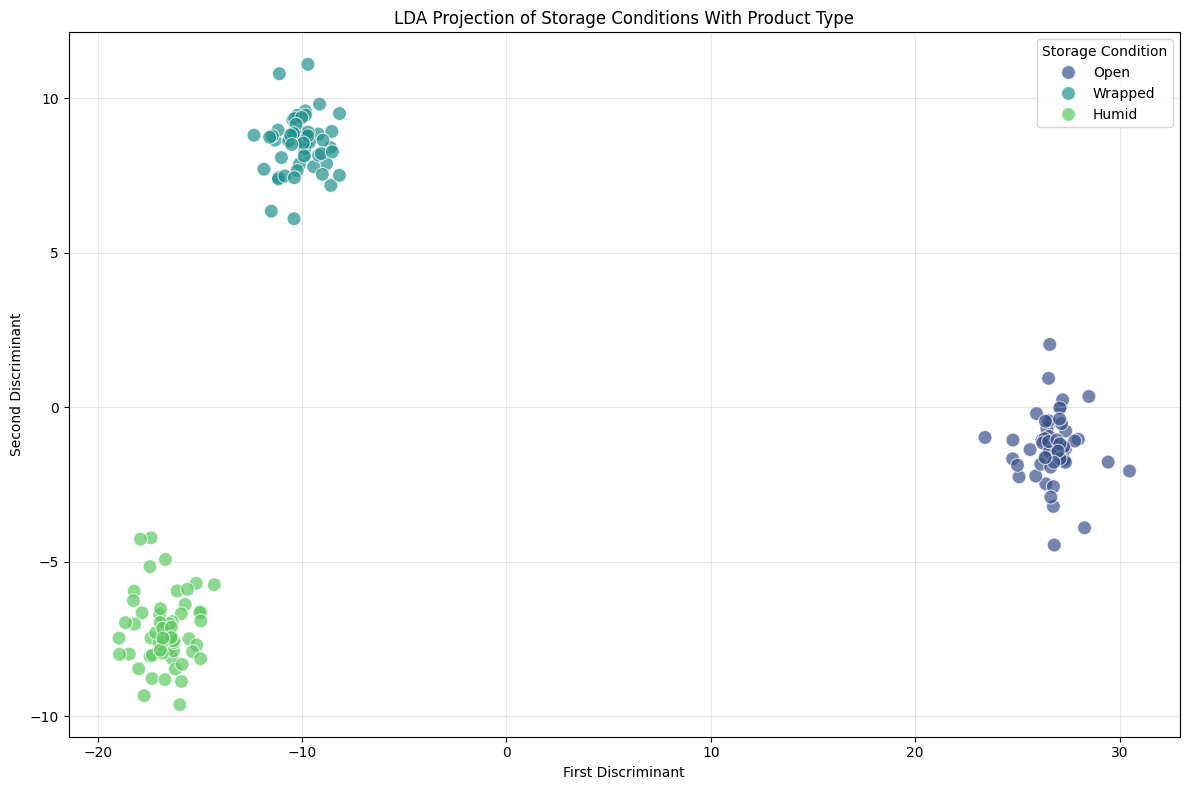

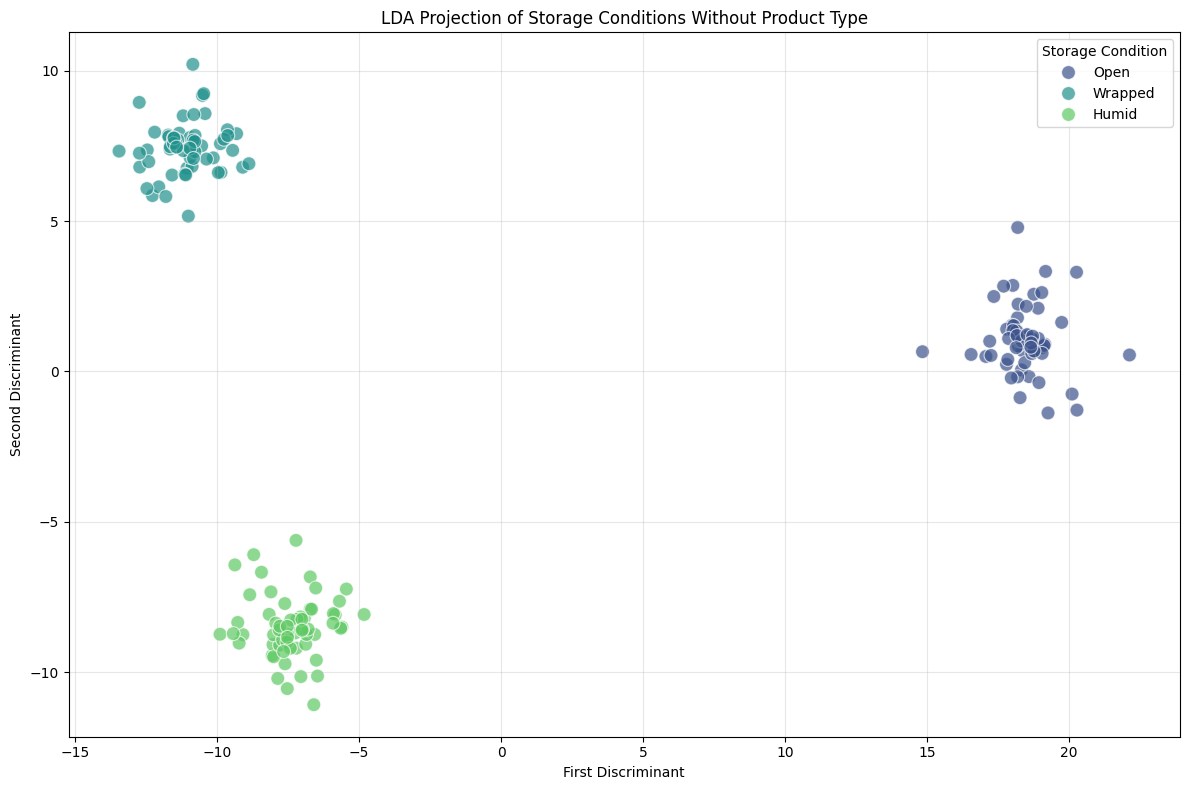


Analyzing LDA coefficients...


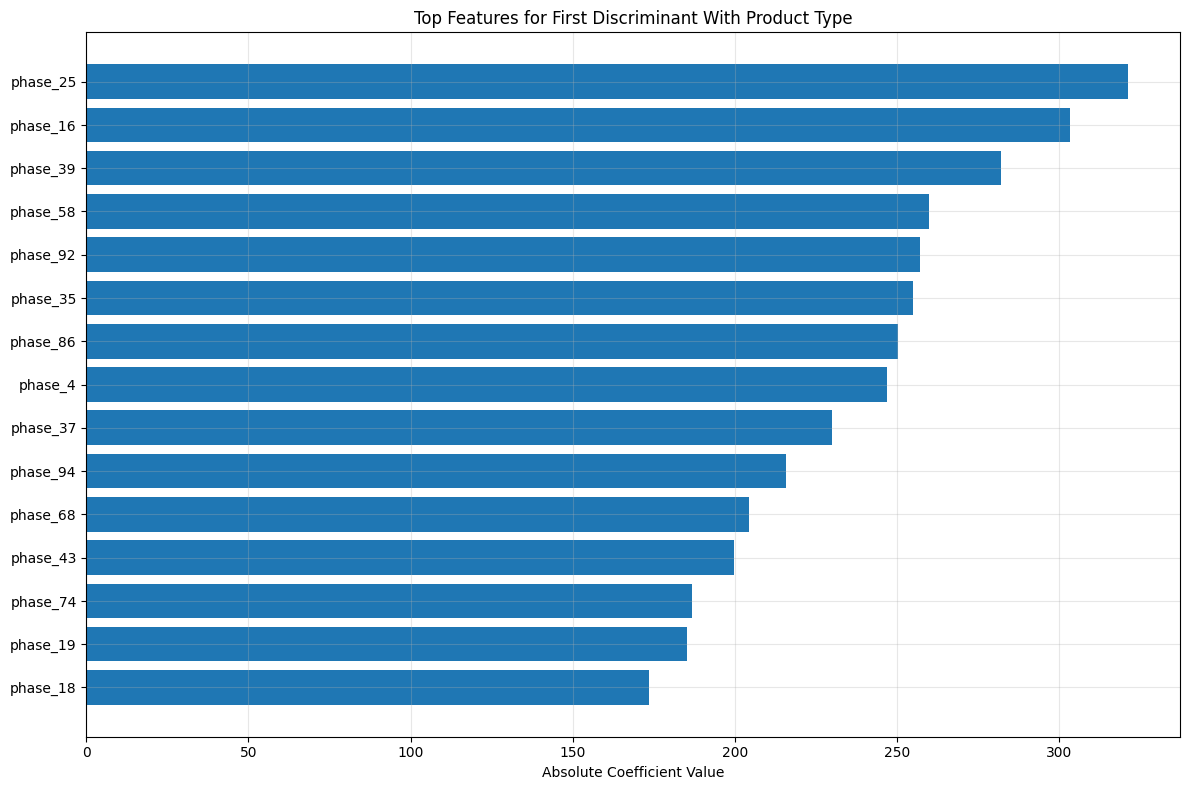

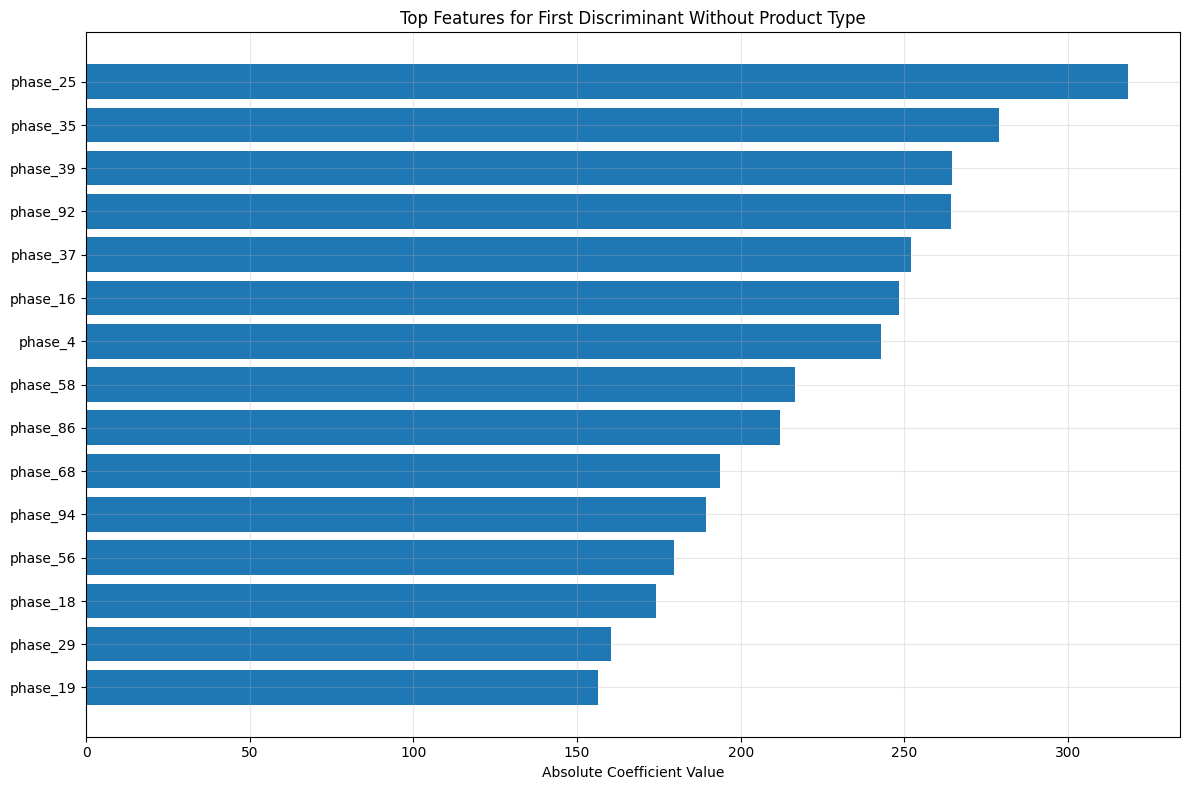


Evaluating models with product type...

Evaluating LDA as a standalone classifier...
LDA Classifier Final Results:
Mean accuracy: 0.5778 ± 0.1319

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.58      0.56        60
           1       0.65      0.62      0.63        60
           2       0.56      0.53      0.55        60

    accuracy                           0.58       180
   macro avg       0.58      0.58      0.58       180
weighted avg       0.58      0.58      0.58       180


Evaluating SVM with LDA preprocessing...
SVM+LDA Final Results:
Mean accuracy: 0.4056 ± 0.0558

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.22      0.30        60
           1       0.40      0.57      0.47        60
           2       0.38      0.43      0.41        60

    accuracy                           0.41       180
   macro avg       0.43      0.41      0.39       180
we

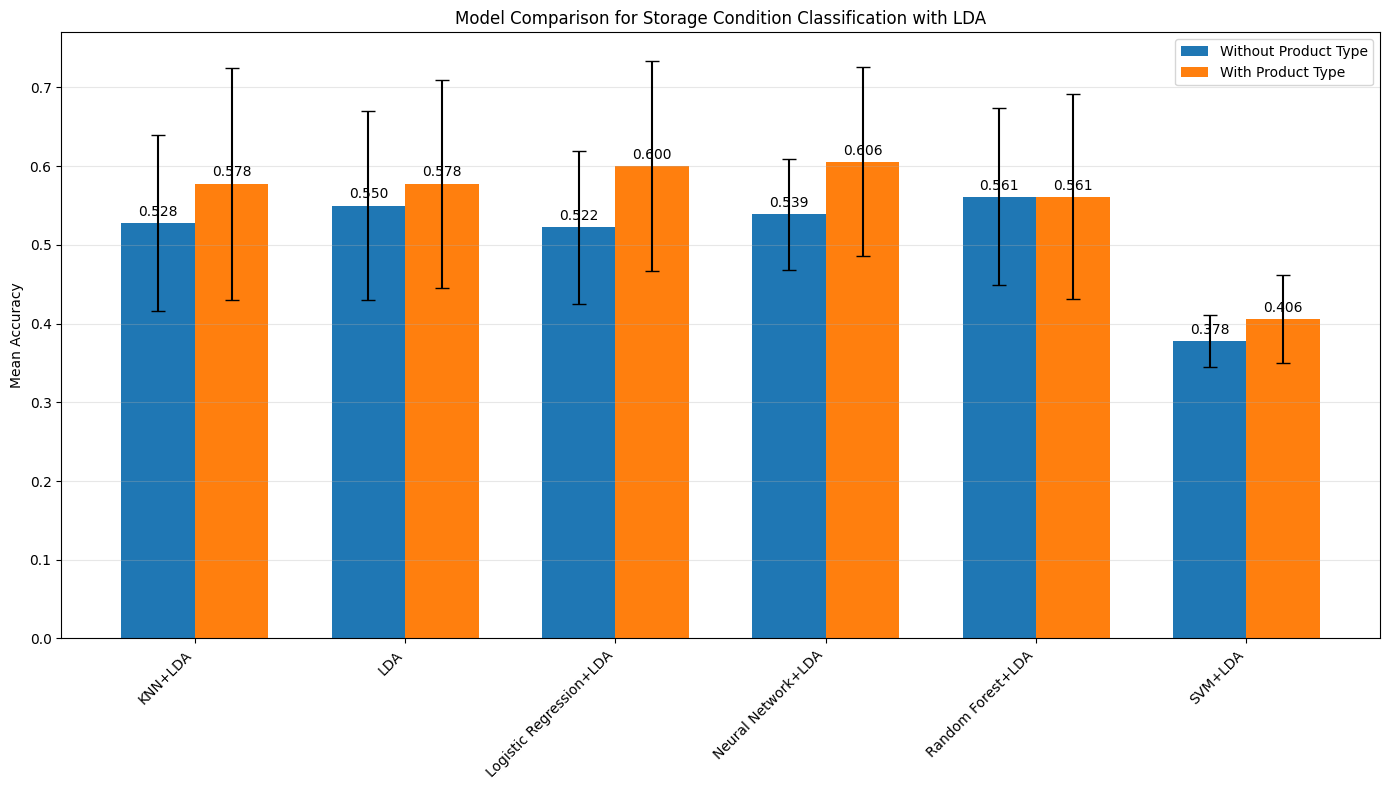


Statistical Analysis Results:

KNN+LDA:
- Without Product Type: 0.5278 ± 0.1118
- With Product Type: 0.5778 ± 0.1474
- Improvement: 5.00%
- Statistical Significance (p < 0.05): No (p = 0.1341)

LDA:
- Without Product Type: 0.5500 ± 0.1203
- With Product Type: 0.5778 ± 0.1319
- Improvement: 2.78%
- Statistical Significance (p < 0.05): No (p = 0.2729)

Logistic Regression+LDA:
- Without Product Type: 0.5222 ± 0.0969
- With Product Type: 0.6000 ± 0.1333
- Improvement: 7.78%
- Statistical Significance (p < 0.05): Yes (p = 0.0248)

Neural Network+LDA:
- Without Product Type: 0.5389 ± 0.0705
- With Product Type: 0.6056 ± 0.1203
- Improvement: 6.67%
- Statistical Significance (p < 0.05): Yes (p = 0.0301)

Random Forest+LDA:
- Without Product Type: 0.5611 ± 0.1124
- With Product Type: 0.5611 ± 0.1302
- Improvement: 0.00%
- Statistical Significance (p < 0.05): No (p = 1.0000)

SVM+LDA:
- Without Product Type: 0.3778 ± 0.0333
- With Product Type: 0.4056 ± 0.0558
- Improvement: 2.78%
- Statistic

In [120]:
# Main Execution
if __name__ == "__main__":
    # 1. Prepare Data
    X_with_product, X_without_product, y_storage, class_labels, feature_cols = prepare_data()
    
    # 2. Load Models
    print("Loading best parameters and creating models...")
    best_params = load_best_parameters()
    if best_params is None:
        print("Warning: Could not load hyperparameter results. Using default parameters.")
        # Create models with default parameters
        models_with_product = {
            'SVM': SVC(probability=True, random_state=RANDOM_STATE),
            'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
            'KNN': KNeighborsClassifier(),
            'Neural Network': MLPClassifier(max_iter=1000, random_state=RANDOM_STATE),
            'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE)
        }
        models_without_product = models_with_product.copy()
    else:
        # Create models with tuned parameters
        models_with_product = create_models(best_params, 'with_product_type')
        models_without_product = create_models(best_params, 'without_product_type')
    
    # 3. Visualize LDA projections
    print("\nVisualizing LDA projections...")
    lda_with_product, X_lda_with = visualize_lda_projections(
        X_with_product, y_storage, class_labels, "With Product Type"
    )
    lda_without_product, X_lda_without = visualize_lda_projections(
        X_without_product, y_storage, class_labels, "Without Product Type"
    )
    
    # 4. Analyze LDA coefficients
    print("\nAnalyzing LDA coefficients...")
    all_features_with_product = feature_cols + ['Product_Type']
    
    coef_with_product = analyze_lda_coefficients(
        lda_with_product, all_features_with_product, "With Product Type"
    )
    coef_without_product = analyze_lda_coefficients(
        lda_without_product, feature_cols, "Without Product Type"
    )
    
    # 5. Evaluate Models
    print("\nEvaluating models with product type...")
    results_with_product = evaluate_models_with_lda(X_with_product, y_storage, models_with_product)
    
    print("\nEvaluating models without product type...")
    results_without_product = evaluate_models_with_lda(X_without_product, y_storage, models_without_product)
    
    # 6. Generate Visualizations and Analysis
    print("\nGenerating visualizations and analysis...")
    
    # Model comparison plot
    plot_model_comparison(results_without_product, results_with_product)
    
    # Confusion matrices with actual class labels
    plot_confusion_matrices(results_without_product, results_with_product, class_labels)
    
    # Statistical analysis
    stats_results = perform_statistical_analysis(results_without_product, results_with_product)
    
    # Learning curves for top models
    # For models with product type
    for model_name in results_with_product.keys():
        if "LDA" in model_name or "+LDA" in model_name:
            if 'pipeline' in results_with_product[model_name]:
                print(f"\nGenerating learning curve for {model_name} with product type...")
                plot_learning_curves_pipeline(
                    X_with_product, 
                    y_storage, 
                    results_with_product[model_name], 
                    model_name + " (with product)"
                )
    
    # For models without product type
    for model_name in results_without_product.keys():
        if "LDA" in model_name or "+LDA" in model_name:
            if 'pipeline' in results_without_product[model_name]:
                print(f"\nGenerating learning curve for {model_name} without product type...")
                plot_learning_curves_pipeline(
                    X_without_product, 
                    y_storage, 
                    results_without_product[model_name], 
                    model_name + " (without product)"
                )
    
    # 7. Save analysis summary and rank models
    save_analysis_summary(results_without_product, results_with_product, stats_results)
    ranked_models = rank_models(results_without_product, results_with_product)
    
    print("\nLDA Storage Condition Analysis Complete!")
    print(f"Results saved to: {RESULTS_DIR}")